In [30]:
import rasterio
import rasterio.plot
from rasterio.crs import CRS
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

# example


In [31]:
x = np.linspace(-4.0, 4.0, 240)
y = np.linspace(-3.0, 3.0, 180)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-2 * np.log(2) * ((X + 1) ** 2 + (Y) ** 2) / 1**2)
Z2 = np.exp(-2 * np.log(2) * ((X - 1) ** 2 + (Y) ** 2) / 1**2)

Z = (90 * Z2 + 5 * Z1) / (Z2 + Z1)
Zn = [Z1, Z2]
Z = np.sum([a*b for a,b in zip(Zn, [5, 90])], axis=0) / np.sum(Zn, axis=0)

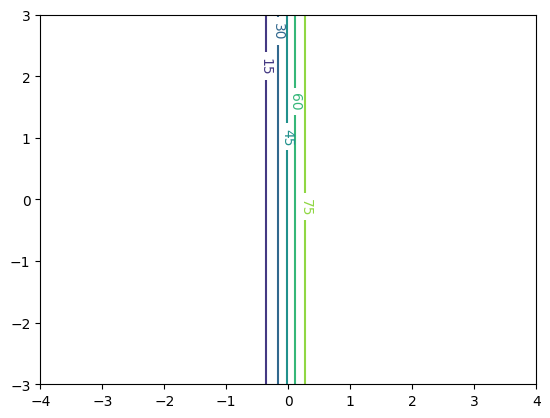

In [32]:
p = plt.contour(X, Y, Z)
plt.clabel(p, inline=1, fontsize=10)
plt.show()

In [33]:
with rasterio.open(
    "new.tif",
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
) as dst:
    dst.write(Z, 1)

/home/till/projects/map/env/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


/home/till/projects/map/env/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


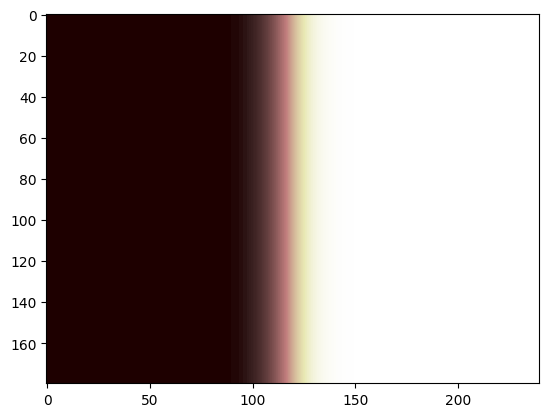

In [34]:
src = rasterio.open("new.tif")
plt.imshow(src.read(1), cmap='pink')
plt.show()

# real


In [35]:
points = gpd.read_file('/home/till/projects/map/waiting_time_per_point.csv')
points.wait = points.wait.astype(float)
points.lat = points.lat.astype(float)
points.lon = points.lon.astype(float)
points = points[points['wait'] <= 100]

points.geometry = gpd.points_from_xy(points.lon, points.lat)
points.crs = CRS.from_epsg(4326)
points = points.to_crs(epsg=3857)

In [ ]:
germany = [5.0, 48.0, 15.0, 55.0]
europe = [-12.0, 35.0, 45.0, 71.0]
world = [-180.0, -85.0, 180.0, 85.0]
map = world

from shapely.geometry import Polygon

polygon = Polygon([(map[0], map[1]), (map[0], map[3]), (map[2], map[3]), (map[2], map[1]), (map[0], map[1])])
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])  
polygon = polygon.to_crs(epsg=3857)

In [ ]:
xx, yy = polygon.geometry[0].exterior.coords.xy

# Note above return values are of type `array.array` 
xx = xx.tolist()
yy = yy.tolist()


In [ ]:
points = points[points.geometry.within(polygon.geometry[0])]

In [ ]:
import numpy as np

def makeGaussian(stdv, x0, y0):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    fwhm = 2.355 * stdv

    return np.exp(-4*np.log(2) * ((X-x0)**2 + (Y-y0)**2) / fwhm**2)

DENSITY = 10
x_density = int(map[2] - map[0]) * DENSITY
y_density = int(map[3] - map[1]) * DENSITY
x = np.linspace(xx[0], xx[2], x_density)
y = np.linspace(yy[0],yy[2], y_density)
X, Y = np.meshgrid(x, y)

# TODO fwhm to stdv
STDV_M = 50000

def get_dist(lat, lon):
    return makeGaussian(STDV_M, lon, lat)


# Zn = [
#     get_dist(lat, lon)
#     for lat, lon in zip(points.geometry.y, points.geometry.x)
# ]

Zn = None
Zn_weighted = None

for lat, lon, wait in tqdm(zip(points.geometry.y, points.geometry.x, points.wait)):
    Zi = get_dist(lat, lon)
    if Zn is None:
        Zn = Zi
        Zn_weighted = Zi * wait
    else:
        Zn = np.sum([Zn, Zi], axis=0)
        Zn_weighted = np.sum([Zn_weighted, Zi * wait], axis=0)

Z = Zn_weighted / Zn

12346it [00:53, 230.64it/s]
/tmp/ipykernel_50969/2941874934.py:45: RuntimeWarning: invalid value encountered in divide
  Z = Zn_weighted / Zn


In [ ]:
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint as GCP


# https://gis.stackexchange.com/questions/425903/getting-rasterio-transform-affine-from-lat-and-long-array

ul = (xx[1], yy[1])  # in lon, lat / x, y order
ll = (xx[0], yy[0])
ur = (xx[2], yy[2])
lr = (xx[3], yy[3])
cols, rows = x_density, y_density

gcps = [
    GCP(0, 0, *ul),
    GCP(0, cols, *ur),
    GCP(rows, 0, *ll),
    GCP(rows, cols, *lr)
]

transform = from_gcps(gcps)

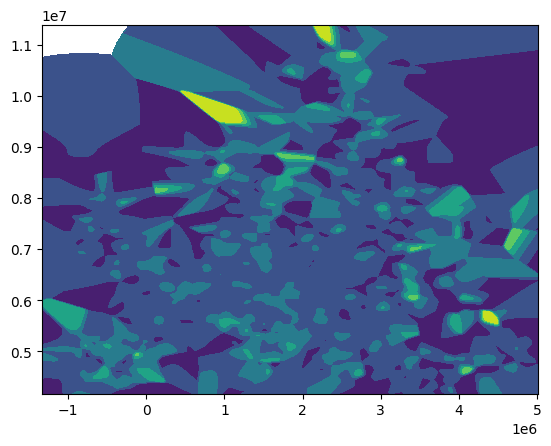

In [ ]:
p = plt.contourf(X, Y, Z)
#plt.clabel(p, inline=1, fontsize=10)
plt.show()

In [ ]:
with rasterio.open(
    "/home/till/projects/map/map/map.tif",
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    crs=CRS.from_epsg(3857),
    transform=transform,
    dtype=Z.dtype,
) as dst:
    dst.write(Z, 1)

/tmp/ipykernel_50969/2204959532.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


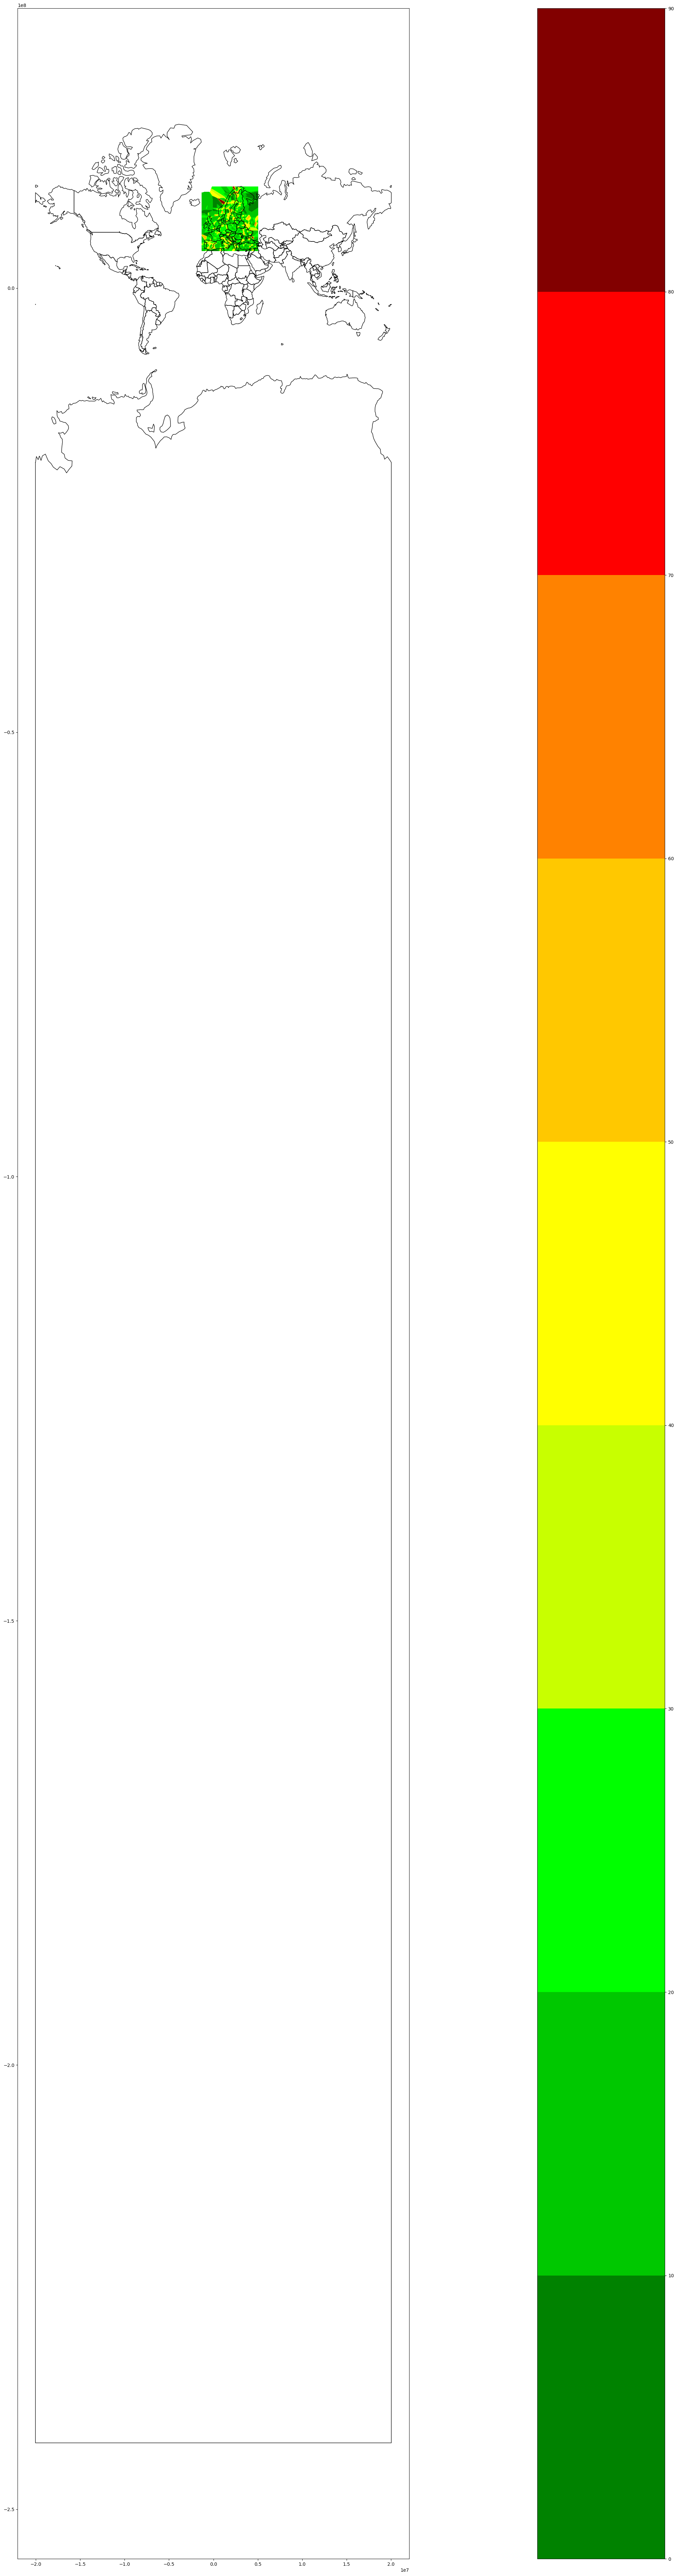

In [ ]:
#countries = gpd.read_file("german_shape/ROR5000.shp")

import matplotlib.colors as colors
from matplotlib import cm

cmap = colors.ListedColormap(['#008200', '#00c800','#00ff00', '#c8ff00', '#ffff00', '#ffc800', '#ff8200', '#ff0000', '#c80000', '#820000'])
boundaries = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

countries = gpd.datasets.get_path("naturalearth_lowres")
countries = gpd.read_file(countries)
countries = countries.to_crs(epsg=3857)
raster = rasterio.open("/home/till/projects/map/map/map.tif")
fig, ax = plt.subplots(figsize=(100, 100))
rasterio.plot.show(raster, origin='lower', ax=ax, cmap=cmap, norm=norm)
countries.plot(ax=ax, facecolor='none', edgecolor='black')

fig.colorbar( cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)